# Imports

In [26]:
import pandas as pd
import numpy as np
import os,  sys
from datetime import datetime, timedelta
from dateutil.relativedelta import *
from dateutil import rrule

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as mtick

from mpl_toolkits import mplot3d

sys.path.append('/Users/benjaminwong/JupyterNotebooks/masters_pfti/notebooks/python/')

from hetanalysis import HetAnalysis
from clean import DrawPointAssayCleaner, PCBCCleaner
import plotter

output_dir = "../outputs/pcbc_vs_dp_wrt_time.ipynb/"
SAVE = True

plt.rcParams.update(
    {
        'font.size': 18
    }
)

# %matplotlib widget

# Monthly

In [27]:
def filter_by_date(df, date):
    return df[(df['date'] >= date) & (df['date'] < (date + relativedelta(months=1)))]

In [28]:
pcbc_df = PCBCCleaner.get_processed_data()
dp_df = DrawPointAssayCleaner.get_processed_data()

In [29]:
pcbc_d = datetime(2021, 12, 1)
pcbc_d = pcbc_d + relativedelta(months=1)
pcbc_d

datetime.datetime(2022, 1, 1, 0, 0)

In [30]:
# Find the months in the datasets
earliest = pcbc_df['date'].dt.date.min()
latest = pcbc_df['date'].dt.date.max()

# earliest dates in the DP assay dataset are in 2020, should check if we can get any dates from the time before that to correlate with PCBC 2015 date.

In [31]:
elements = [
    'CU',
    'AU'
]

def group_by_month(df):
    return_dict = {}
    
    earliest = df['date'].dt.date.min()
    latest = df['date'].dt.date.max()
    for dt in rrule.rrule(rrule.MONTHLY, dtstart=earliest, until=latest):
        filtered_df = filter_by_date(df, datetime(dt.year, dt.month, day=1))
        
        return_dict[dt] = {}
        date = f'{dt.year}_{dt.month}'
        for element in elements:
            try:
                return_dict[dt][element] = HetAnalysis(f'{date}_{element}', filtered_df['weight'], filtered_df[element])
            except:
                print(f'Invalid data for {date}_{element}')
                
    return return_dict

In [32]:
pcbc_groups = group_by_month(pcbc_df)
dp_groups = group_by_month(dp_df)

# # Find the months in the datasets
# # earliest dates in the DP assay dataset are in 2020, should check if we can get any dates from the time before that to correlate with PCBC 2015 date.

# earliest = pcbc_df['date'].dt.date.min()
# latest = pcbc_df['date'].dt.date.max()
# for dt in rrule.rrule(rrule.MONTHLY, dtstart=earliest, until=latest):
#     filtered_pcbc_df = filter_by_date(pcbc_df, datetime(dt.year, dt.month, day=1))
#     # print(f'{dt.year}_{dt.month}: {len(filtered_pcbc_df)}')
    
#     pcbc_groups[dt] = {}
#     date = f'{dt.year}_{dt.month}'
#     for element in elements:
#         try:
#             pcbc_groups[dt][element] = HetAnalysis(f'{date}_{element}', filtered_pcbc_df['weight'], filtered_pcbc_df[element])
#         except:
#             print(f'Invalid data for {date}_{element}')

In [33]:
pcbc_d, pcbc_h, pcbc_g = [], [], []
for date, group in pcbc_groups.items():
    pcbc_d.append(date)
    pcbc_h.append(group['CU'].get_heterogeneity())
    pcbc_g.append(group['CU'].get_grade())
    
dp_d, dp_h, dp_g = [], [], []
for date, group in dp_groups.items():
    dp_d.append(date)
    dp_h.append(group['CU'].get_heterogeneity())
    dp_g.append(group['CU'].get_grade())

Text(0.5, 1.0, 'CU Grade/Heterogeneity wrt to Time')

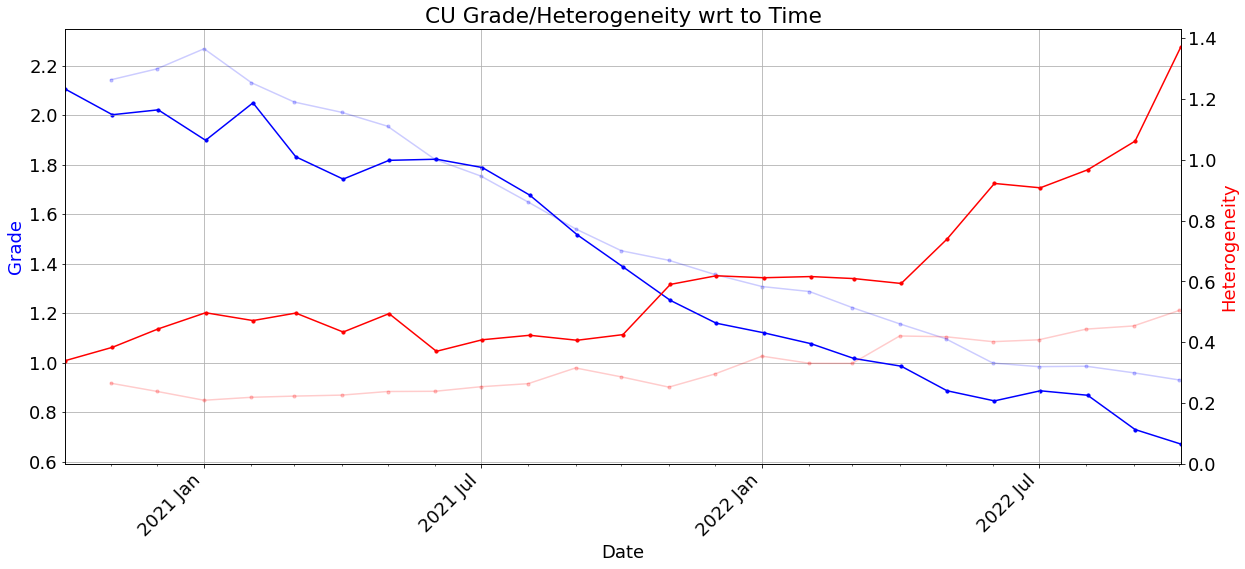

In [34]:
import matplotlib.dates as mdates

fig = plt.figure()
fig.set_size_inches(20, 8)

ax = fig.add_subplot()
sec_ax = ax.twinx()

sec_ax.plot(pcbc_d, pcbc_h, alpha=0.2, c='red', ls='-')
sec_ax.scatter(pcbc_d, pcbc_h, alpha=0.2, c='red', s=10)

sec_ax.plot(dp_d, dp_h, alpha=1, c='red', ls='-')
sec_ax.scatter(dp_d, dp_h, c='red', s=10)

sec_ax.set_ylim(0)
sec_ax.set_ylabel('Heterogeneity', c='red')

ax.set_xlim(min(dp_d), max(dp_d))
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y %b'))

#ax.xaxis.set_label_coords(0, 0)

for label in ax.get_xticklabels(which='major'):
    label.set(rotation=45, horizontalalignment='right')

ax.set_xlabel('Date')

ax.plot(pcbc_d, pcbc_g, alpha=0.2, c='blue', ls='-')
ax.scatter(pcbc_d, pcbc_g, alpha=0.2, c='blue', s=10)

ax.plot(dp_d, dp_g, alpha=1, c='blue', ls='-')
ax.scatter(dp_d, dp_g, c='blue', s=10)

# sec_ax.plot(w, ig['CU'], alpha=0.2, c='black', ls='--')
# sec_ax.scatter(w, ig['CU'], c='black', s=3)

ax.set_ylabel('Grade', c='blue')
ax.grid()

ax.set_title(f'CU Grade/Heterogeneity wrt to Time')  # TODO: Change CU to element

# Compare

In [35]:
dhids = list(pcbc_df['dhid'].unique())

In [36]:
elements = [
    'CU',
    'AU'
]

pcbc_groups = {}
dp_groups = {}

for dhid in dhids:
    filtered_pcbc_df = pcbc_df.query('dhid == @dhid')
    filtered_dp_df = dp_df.query('dhid == @dhid')
    
    pcbc_groups[dhid] = {}
    dp_groups[dhid] = {}
    
    for element in elements:
        try:
            pcbc_groups[dhid][element] = HetAnalysis(f'{dhid}_{element}', filtered_pcbc_df['weight'], filtered_pcbc_df[element])
            dp_groups[dhid][element] = HetAnalysis(f'{dhid}_{element}', filtered_dp_df['weight'], filtered_dp_df[element])
        except:
            print(f'Invalid data for {dhid}_{element}')

In [37]:
dhid = 'P20-10E'
element = 'CU'

filtered_pcbc_df = pcbc_df.query('dhid == @dhid')
filtered_dp_df = dp_df.query('dhid == @dhid')

# pcbc_groups[dhid] = {}
# dp_groups[dhid] = {}

# for element in elements:
#     try:
#         pcbc_groups[dhid][element] = HetAnalysis(f'{dhid}_{element}', filtered_pcbc_df['weight'], filtered_pcbc_df[element])
#         dp_groups[dhid][element] = HetAnalysis(f'{dhid}_{element}', filtered_dp_df['weight'], filtered_dp_df[element])
#     except:
#         print(f'Invalid data for {dhid}_{element}')

# elements = [
#     'CU',
#     'AU'
# ]

# dp_timeslices = {}

# filtered_df = pcbc_df.query('dhid == @dhid').dropna(subset=elements).reset_index(drop=True)

# indices = filtered_df.index.to_list()

# ig = {}
        

In [38]:
filtered_dp_df['date']

150     2020-10-06
345     2020-10-17
598     2020-10-26
794     2020-11-06
833     2020-11-08
           ...    
20180   2022-09-13
20536   2022-09-23
21084   2022-10-04
21439   2022-10-11
22014   2022-10-24
Name: date, Length: 63, dtype: datetime64[ns]

Text(0.5, 1.0, 'P20-10E CU Grade/Weight Percentage wrt to Time')

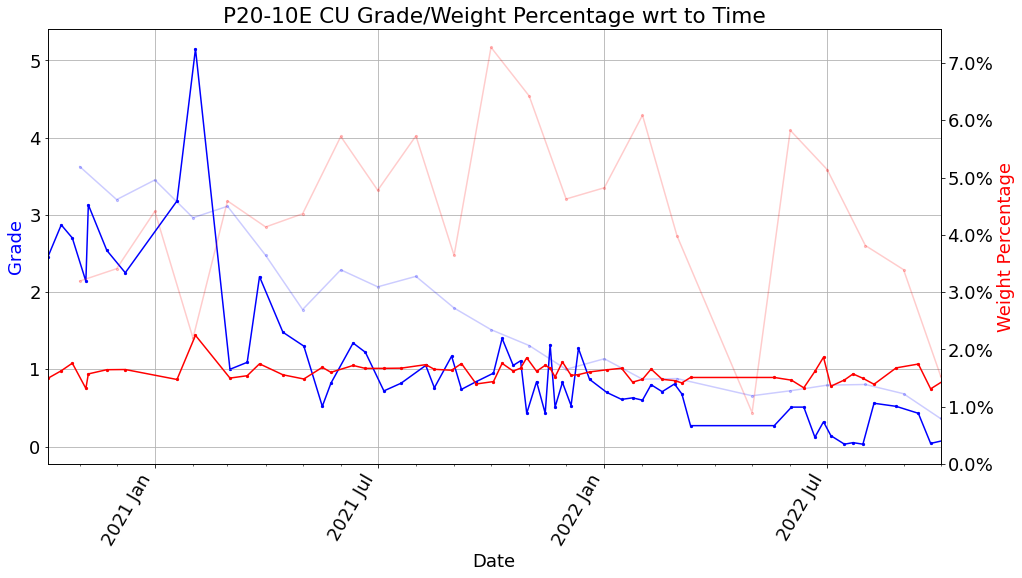

In [39]:
fig = plt.figure()
fig.set_size_inches(16, 8)

ax = fig.add_subplot()
sec_ax = ax.twinx()

pcbc_total_weight = filtered_pcbc_df['weight'].sum()
dp_total_weight = filtered_dp_df['weight'].sum()

sec_ax.plot(filtered_pcbc_df['date'], filtered_pcbc_df['weight'] / pcbc_total_weight, alpha=0.2, c='red', ls='-')
sec_ax.scatter(filtered_pcbc_df['date'], filtered_pcbc_df['weight'] / pcbc_total_weight, alpha=0.2, s=5, c='red', ls='-')

sec_ax.plot(filtered_dp_df['date'], filtered_dp_df['weight'] / dp_total_weight, alpha=1, c='red', ls='-')
sec_ax.scatter(filtered_dp_df['date'], filtered_dp_df['weight'] / dp_total_weight, alpha=1, s=5, c='red', ls='-')

sec_ax.set_ylim(0)
sec_ax.set_ylabel('Weight Percentage', c='red')
sec_ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

ax.set_xlim(min(filtered_dp_df['date']), max(filtered_pcbc_df['date']))
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y %b'))

for label in ax.get_xticklabels(which='major'):
    label.set(rotation=60, horizontalalignment='right')

ax.set_xlabel('Date')

ax.plot(filtered_pcbc_df['date'], filtered_pcbc_df[element], alpha=0.2, c='blue', ls='-')
ax.scatter(filtered_pcbc_df['date'], filtered_pcbc_df[element], alpha=0.2, s=5, c='blue')

ax.plot(filtered_dp_df['date'], filtered_dp_df[element], alpha=1, c='blue', ls='-')
ax.scatter(filtered_dp_df['date'], filtered_dp_df[element], alpha=1, s=5, c='blue')

ax.set_ylabel('Grade', c='blue')

ax.grid()
ax.set_title(f'{dhid} {element} Grade/Weight Percentage wrt to Time')

In [15]:
_.get_info()

AttributeError: 'Text' object has no attribute 'get_info'